<a href="https://colab.research.google.com/github/codiak/ds_notebooks/blob/main/NASA_Dataset_Near_Earth_Object_Hazard_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Identifying Dangerous Near-Earth Objects

Using a NASA dataset of nearest Earth objects available through Kaggle, I will be building a model to identify hazardous objects.

In [168]:
# library imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set()


### Data Import and Initial Inspection

In [6]:
# Kaggle dataset:
# https://www.kaggle.com/datasets/sameepvani/nasa-nearest-earth-objects?resource=download
# NASA - Nearest Earth Objects

df = pd.read_csv("neo.csv")

df.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  90836 non-null  int64  
 1   name                90836 non-null  object 
 2   est_diameter_min    90836 non-null  float64
 3   est_diameter_max    90836 non-null  float64
 4   relative_velocity   90836 non-null  float64
 5   miss_distance       90836 non-null  float64
 6   orbiting_body       90836 non-null  object 
 7   sentry_object       90836 non-null  bool   
 8   absolute_magnitude  90836 non-null  float64
 9   hazardous           90836 non-null  bool   
dtypes: bool(2), float64(5), int64(1), object(2)
memory usage: 5.7+ MB


Our dataset has 90,836 observations and 8 features (not including 'id' or the 'hazardous' label), and it looks like each one has each feature provided.

### Data Cleaning

There are no null values according to dataframe.info(), but let's verify that there are no "null-like" values as well.

In [11]:
null_like = [np.nan, None, [], {}, 'NaN', 'Null','NULL','None','NA','?','-', '.', '', ' ', '   ']

for c in df.columns:
    string_null = np.array([x in null_like for x in df[c]])
    print(c, df[c].isnull().sum(), string_null.sum()) 

id 0 0
name 0 0
est_diameter_min 0 0
est_diameter_max 0 0
relative_velocity 0 0
miss_distance 0 0
orbiting_body 0 0
sentry_object 0 0
absolute_magnitude 0 0
hazardous 0 0


Looks like this is a nicely prepared dataset without missing values. We can further explore each feature to see if anything is unusual about any of the counts. 

We will also drop the "name" and "id" columns since they will not provide any useful information for our model.

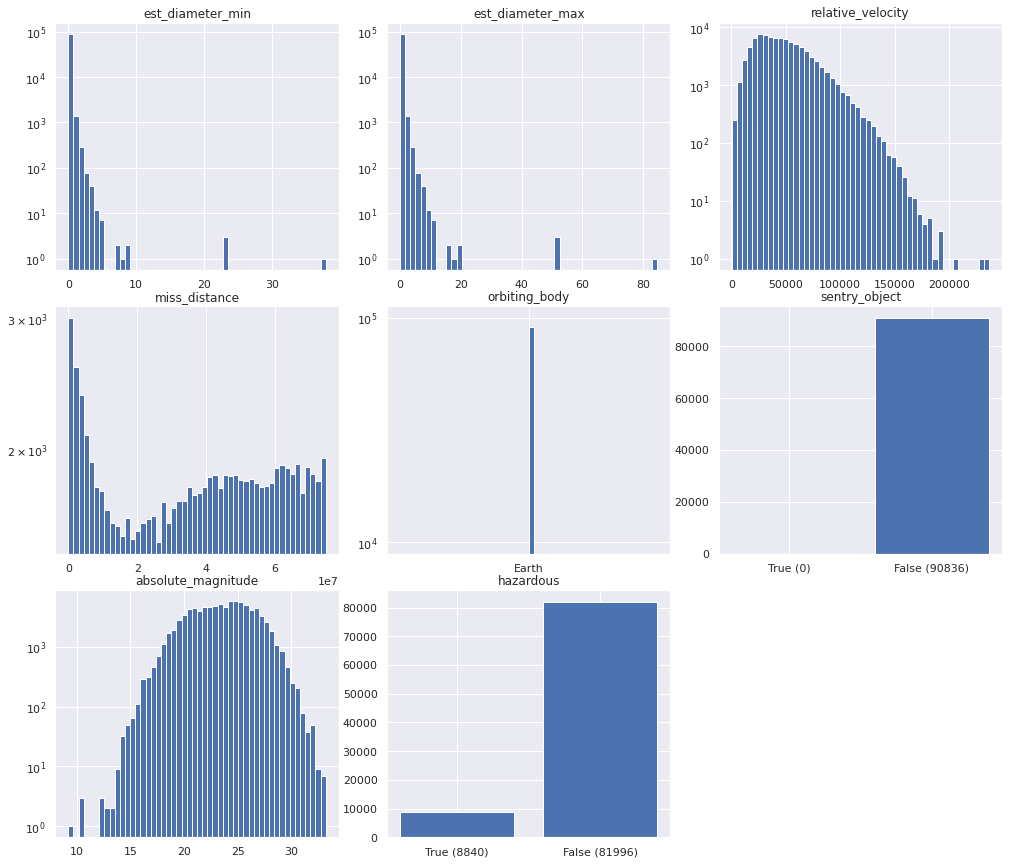

In [114]:
cleaned = df.drop(columns=["name", "id"])

fig, a = plt.subplots(3,3) 
fig.set_figheight(12)
fig.set_figwidth(14)
fig.tight_layout()

for i, c in enumerate(cleaned.columns):
  data = cleaned[c]
  ax = a.flat[i]
  if data.dtype == 'bool':
    trues = np.count_nonzero(data)
    falses = np.size(data) - trues
    ax.bar(["True ({})".format(trues), "False ({})".format(falses)], [trues, falses])
  else:
    ax.hist(data, bins=50, log=True)
  ax.set_title(c)

for i in range(8,9):
  a.flat[i].set_visible(False)

#### Distribution Analysis

Looking at these histograms of the data, we can see:


*   "sentry_object" adds no information since all are False, and can be dropped
*   The only value for "orbiting_body" is "Earth", so it can be dropped as well
*   A logarthmic spread was needed to display this most of these features, particularly the "diameter" values, so larger values in those cases are rarer.
*   Even though we checked for null values, it looks like there might be a large number of zeros, and it might be worth verifying the minimum values for a few features.



In [115]:
# First lets drop the "sentry_object" feature
cleaned = cleaned.drop(columns=["sentry_object", "orbiting_body"])

# Then lets output minimum values and zero counts for each feature with a lot of potential zeros
for c in ["est_diameter_min", "est_diameter_max", "relative_velocity", "miss_distance"]:
  col = cleaned[c]
  zeros = np.size(col) - np.count_nonzero(col)
  print("For column {}: {} zeros, {} minimum value".format( c, zeros, col.min()))

For column est_diameter_min: 0 zeros, 0.0006089126 minimum value
For column est_diameter_max: 0 zeros, 0.00136157 minimum value
For column relative_velocity: 0 zeros, 203.34643253 minimum value
For column miss_distance: 0 zeros, 6745.532515957 minimum value


Confirmed the data is not full of zeros, and unnecessary columns have been dropped.

In [90]:
cleaned.head()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,absolute_magnitude,hazardous
0,1.198271,2.679415,13569.249224,5.483974e+07,Earth,16.73,False
1,0.265800,0.594347,73588.726663,6.143813e+07,Earth,20.00,True
2,0.722030,1.614507,114258.692129,4.979872e+07,Earth,17.83,False
3,0.096506,0.215794,24764.303138,2.543497e+07,Earth,22.20,False
4,0.255009,0.570217,42737.733765,4.627557e+07,Earth,20.09,True


### Exploratory Data Analysis

EDA above and
beyond
expectations. E.g.
in addition to
simple plots, the
author included at
least two of the
following (or
similar):

● good analysis
and conclusions
/ discussions

● correlation
matrix with
analysis

● extra EDA (E.g.
statistical tests

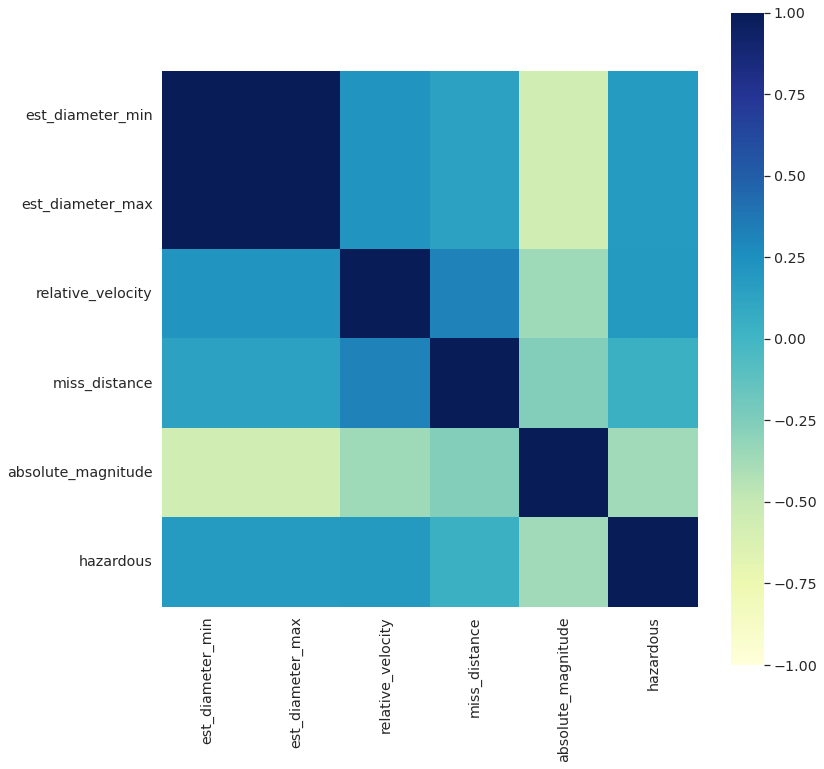

In [93]:
corr = cleaned.corr()
plt.subplots(figsize=(12,12))
sns.set(font_scale=1.3)
sns.heatmap(data=corr, vmin=-1, vmax=1, cmap="YlGnBu", square=True, yticklabels=True)


**Correlation Matrix Analysis**

Based on the correlation matrix, it looks like "miss_distance" has the weakest correlation, and the rest of the features are roughly equivalent.

Looking at the actual values below, we can see that "absolute_magnitude" has the strongest correlation (-0.36) with "hazardous" and we can assume will be our strongest predictor. The second strongest is "relative_velocity", followed by "est_diameter_min"/"est_diameter_max".

For further analysis, I've also added a pair plot below.

In [94]:
print(corr)

                    est_diameter_min  est_diameter_max  relative_velocity  \
est_diameter_min            1.000000          1.000000           0.221553   
est_diameter_max            1.000000          1.000000           0.221553   
relative_velocity           0.221553          0.221553           1.000000   
miss_distance               0.142241          0.142241           0.327169   
absolute_magnitude         -0.560188         -0.560188          -0.353863   
hazardous                   0.183363          0.183363           0.191185   

                    miss_distance  absolute_magnitude  hazardous  
est_diameter_min         0.142241           -0.560188   0.183363  
est_diameter_max         0.142241           -0.560188   0.183363  
relative_velocity        0.327169           -0.353863   0.191185  
miss_distance            1.000000           -0.264168   0.042302  
absolute_magnitude      -0.264168            1.000000  -0.365267  
hazardous                0.042302           -0.365267   1.

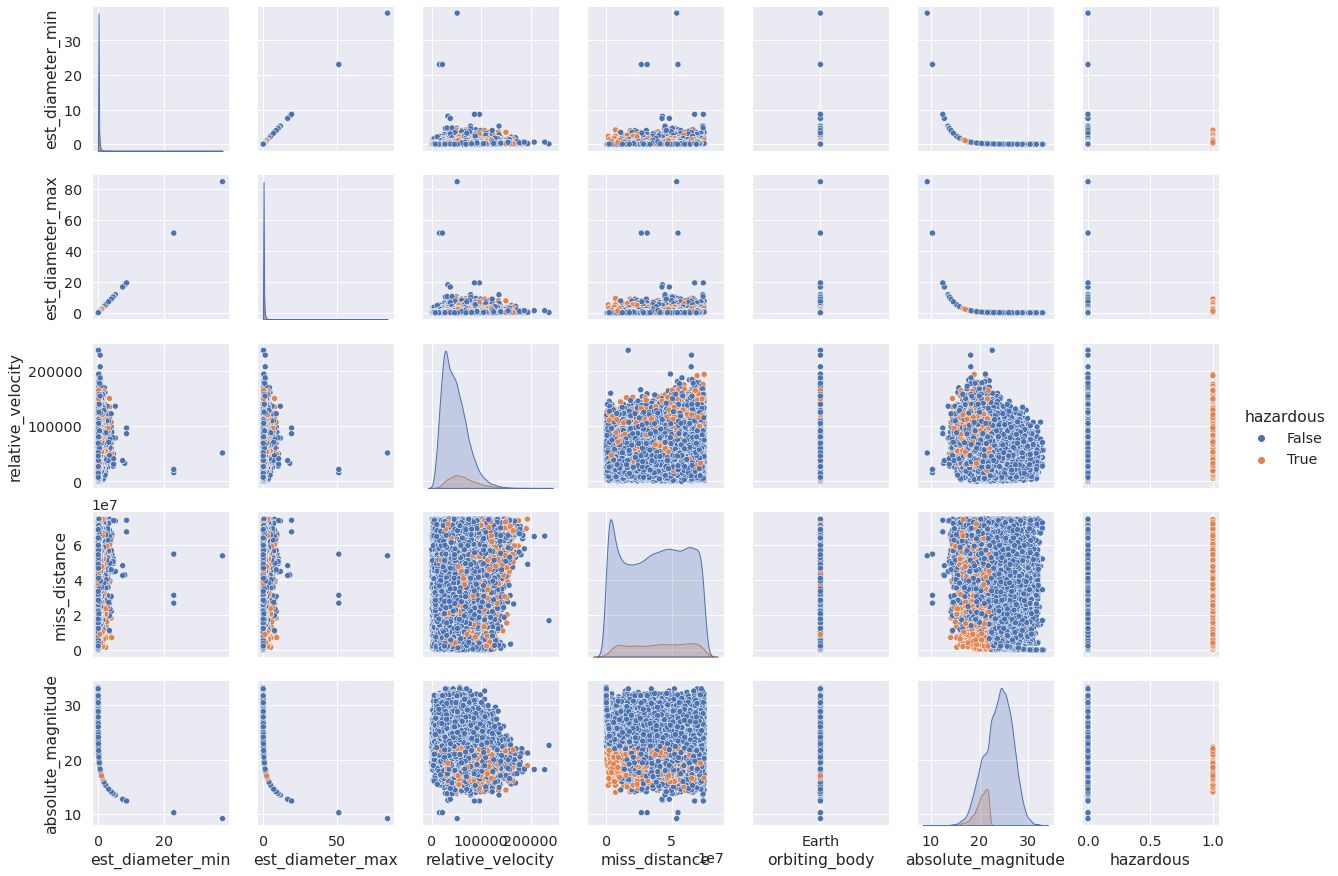

In [104]:
# Specifying y vars to avoid unsupported boolean comparison
sns.pairplot(cleaned, x_vars=cleaned.columns, 
             y_vars=["est_diameter_min", "est_diameter_max", "relative_velocity", "miss_distance", "absolute_magnitude"], 
             diag_kind="kde",
             hue="hazardous")

**Pair Plot Analysis**

Based on the pair plots, as well as the correlation matrix, we may need to consider removing "miss_distance" or using it to engineer another feature since it may add unneeded complexity to the model.

### Logistic Regression

The first model to build and test will be a Logistic Regression. Features are exponentially distributed, mostly qunatitative, and otherwise not very sparse, so it should work well with this dataset. It can be used as a baseline for testing out other types of models as well.

In [145]:
# Prepare the data for training
shuffle(cleaned)
x = cleaned.drop(columns="hazardous")
y = cleaned["hazardous"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

print("Training dataset sizes: {} in x_train, {} in y_train".format(len(x_train),len(y_train)))
print("Test dataset sizes: {} in x_test, {} in y_test".format(len(x_test), len(y_test)))

Training dataset sizes: 72668 in x_train, 72668 in y_train
Test dataset sizes: 18168 in x_test, 18168 in y_test


Text(0.65, 0.3, 'AUC=0.391')

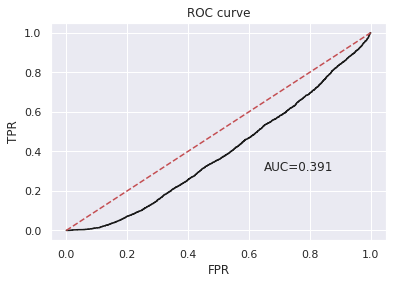

In [130]:
# Train initial, default model
LogReg = LogisticRegression().fit(x_train, y_train)

# Predict using model
y_pred = LogReg.predict(x_test)

# Evalluate model
yp_proba = LogReg.predict_proba(x_test)
fpr, tpr, th = roc_curve(y_test, yp_proba[:,1])
auc = roc_auc_score(y_test, yp_proba[:,1])

# plot
plt.plot(fpr, tpr, 'k-')
plt.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), 'r--')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.text(0.65, 0.3, 'AUC='+"{:.3f}".format(auc))

Based on the ROC the default parameters for LogisticRegression result in a weak model. 

In [153]:
from sklearn.model_selection import GridSearchCV

model = LogisticRegression()
# Params
# First attempt using np.logspace(-6, 6,num=11, base=10), and 10^-6 was the best value
crange = np.logspace(-10, -6, num=5, base=10)
grid = {
      "solver": ['newton-cg'],
      "C": crange,
    }

grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=5)
grid_result = grid_search.fit(x, y)
# summarize results
print("Best params: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

Accuracy rate of Logistic Regression: 0.902682 using {'C': 1e-08, 'solver': 'newton-cg'}


/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,


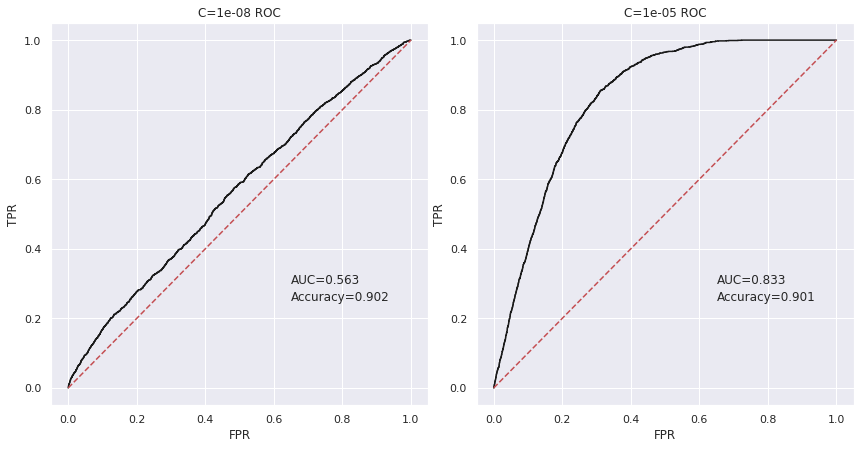

In [166]:
# Train initial, default model
best_log_reg = LogisticRegression(solver='newton-cg', C=1e-08, n_jobs=-1).fit(x_train, y_train)
better_roc_log_reg = LogisticRegression(solver='newton-cg', C=1e-05, n_jobs=-1).fit(x_train, y_train)

fig, (a1, a2) = plt.subplots(1,2) 
fig.set_figheight(6)
fig.set_figwidth(12)
fig.tight_layout()

# Evaluate model
def plot_roc_vals(title, model, plot):
  y_pred = model.predict(x_test)
  yp_proba = model.predict_proba(x_test)
  fpr, tpr, th = roc_curve(y_test, yp_proba[:,1])
  auc = roc_auc_score(y_test, yp_proba[:,1])
  accuracy = accuracy_score(y_test, y_pred)

  # plot
  plot.plot(fpr, tpr, 'k-')
  plot.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), 'r--')
  plot.set_title(title)
  plot.set_xlabel('FPR')
  plot.set_ylabel('TPR')
  plot.text(0.65, 0.3, 'AUC='+"{:.3f}".format(auc))
  plot.text(0.65, 0.25, 'Accuracy='+"{:.3f}".format(accuracy))

plot_roc_vals('C=1e-08 ROC', best_log_reg, a1)
plot_roc_vals('C=1e-05 ROC', better_roc_log_reg, a2)


**Analysis**

Logistic Regression was able to achieve decent accuracy with optimized parameters, but it's ROC curve suggests a high number of False Negatives since it skews up and to the right.

The confusion matrix confirms this:

[[16370    12]
 [ 1780     6]]


[Text(0, 0.5, 'Not Hazard'), Text(0, 1.5, 'Hazardous')]

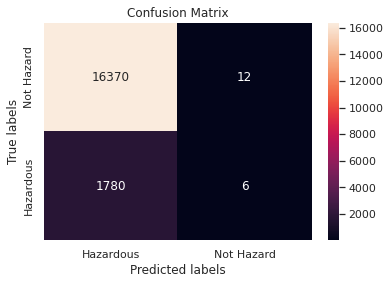

In [172]:
y_pred = better_roc_log_reg.predict(x_test)
confusion = confusion_matrix(y_test, y_pred)
print(confusion)
ax = plt.subplot()
sns.heatmap(confusion, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Hazardous', 'Not Hazard'])
ax.yaxis.set_ticklabels(['Not Hazard', 'Hazardous'])


#### Comparing Logistic Regression to SVM



